### Generate multiple yield vs time curves from Kinetic Simulations ###

Here we fix a kinetic protocol (rategrowth, diversification) and the type of optimization (kon or dG) and generate yield vs time curves at different concentration ranges. To change concentration before starting a simulation run, we can either edit the input file or directly modify the initial concentration in the Reaction Network. Finally after a simulation, the data is stored in a corresponding file (with a template prefix). The path to these files are to be given to the Optimizer. 

### Import necessary modules ### 

Make sure the path variable in the sys has the location of the python source files located in the KineticAssembly_AD dir. 

In [1]:
# make sure jupyter path is correct for loading local moudules
import sys
# path to steric_simulator module relative to notebook
sys.path.append("../../../")
import copy
from KineticAssembly_AD import ReactionNetwork, VectorizedRxnNet, VecSim, Optimizer, EquilibriumSolver
import networkx as nx
import torch
from torch import DoubleTensor as Tensor

In [2]:
print(torch.__version__)

1.4.0


### Reading in a input file ###

Create an input file following instructions in the UserGuide or use the template input file (tetramer_rategrowth.pwr). 

Specify the kinetic protocol in the parameter block. The input files for a rategrowth and diversification are similar to the one used for optimization of kinetic traps. For predicting the free energies from experimental data, we need to add three more parameters to the parameter block: 

dG_is_param = True  ; This flag enables the koff(dG) to be considered as parameters and are optimized as well.

dG_fluc_min = -dG_min   ; This value acts as a minimum value a dG can reach during optimization beyond which a     regularization penalty will be applied. (Stable region)

dG_flux_max = -dG_max   ; Maximum threshold on the dG value. (Weaker region)

In [3]:
base_input = './tetramer_rategrowth.pwr'
rn = ReactionNetwork(base_input, one_step=True)

rn.resolve_tree()

['default_assoc', 1.0]
['monomer_add_only', True]
['homo_rates', True]
New node added - Node index: 4 ; Node label: AM 
New node added - Node index: 5 ; Node label: AB 
New node added - Node index: 6 ; Node label: AS 
Trying internal bonds
New node added - Node index: 7 ; Node label: BM 
New node added - Node index: 8 ; Node label: MS 
New node added - Node index: 9 ; Node label: ABM 
New node added - Node index: 10 ; Node label: AMS 
Trying internal bonds
New node added - Node index: 11 ; Node label: BS 
New node added - Node index: 12 ; Node label: ABS 
New node added - Node index: 13 ; Node label: BMS 
New node added - Node index: 14 ; Node label: ABMS 
The number of bonds formed are not compensated by the number of edges
This could be possible due to presence of a repeating subunit
SOurce1:  2 10
The common reactant is:  B
Edge added between:  2 14
Trying internal bonds
The number of bonds formed are not compensated by the number of edges
This could be possible due to presence of a

## Checking reaction network
Looping over all network nodes to check if all species are created
Creating a dictionary for later reference. This dictionary holds the reactants as keys and values as the reaction index

In [4]:
uid_dict = {}
react_dict = {}
sys.path.append("../../")
nodes_list = []
import numpy as np
from reaction_network import gtostr
for n in rn.network.nodes():
    print(n,"--",gtostr(rn.network.nodes[n]['struct']))
    nodes_list.append(gtostr(rn.network.nodes[n]['struct']))
    for r_set in rn.get_reactant_sets(n):
        r_tup = tuple(list(r_set)+[n])
#         print(r_tup)
        data = rn.network.get_edge_data(r_tup[0], n)
        reaction_id = data['uid']
        react_dict[r_tup]=reaction_id
    for k,v in rn.network[n].items():
        uid = v['uid']
        r1 = set(gtostr(rn.network.nodes[n]['struct']))
        p = set(gtostr(rn.network.nodes[k]['struct']))
        r2 = p-r1
        reactants = ("".join(r1),"".join(r2))
#         print(reactants)
        uid_dict[(n,k)] = uid
#         react_dict[reactants] = uid

print(uid_dict)
print(react_dict)

0 -- A
1 -- M
2 -- B
3 -- S
4 -- AM
5 -- AB
6 -- AS
7 -- BM
8 -- MS
9 -- ABM
10 -- AMS
11 -- BS
12 -- ABS
13 -- BMS
14 -- ABMS
{(0, 4): 0, (0, 5): 1, (0, 6): 2, (0, 9): 16, (0, 10): 17, (0, 12): 18, (0, 14): 21, (1, 4): 0, (1, 7): 3, (1, 8): 4, (1, 9): 5, (1, 10): 6, (1, 13): 19, (1, 14): 20, (2, 5): 1, (2, 7): 3, (2, 11): 7, (2, 9): 8, (2, 12): 9, (2, 13): 10, (2, 14): 11, (3, 6): 2, (3, 8): 4, (3, 11): 7, (3, 10): 12, (3, 12): 13, (3, 13): 14, (3, 14): 15, (4, 9): 8, (4, 10): 12, (5, 9): 5, (5, 12): 13, (6, 10): 6, (6, 12): 9, (7, 13): 14, (7, 9): 16, (8, 13): 10, (8, 10): 17, (9, 14): 15, (10, 14): 11, (11, 12): 18, (11, 13): 19, (12, 14): 20, (13, 14): 21}
{(0, 1, 4): 0, (0, 2, 5): 1, (0, 3, 6): 2, (1, 2, 7): 3, (1, 3, 8): 4, (1, 5, 9): 5, (2, 4, 9): 8, (0, 7, 9): 16, (3, 4, 10): 12, (1, 6, 10): 6, (8, 0, 10): 17, (2, 3, 11): 7, (3, 5, 12): 13, (0, 11, 12): 18, (2, 6, 12): 9, (8, 2, 13): 10, (3, 7, 13): 14, (1, 11, 13): 19, (9, 3, 14): 15, (1, 12, 14): 20, (0, 13, 14): 21, (10, 2, 

## Set the initial parameter values 
For a tetramer model there are 22 reactions. We can set an initial value for all reaction rates as given in the next cell. 

For the Rategrowth, the number of rates decrease to only 3 values. To set the initial values for all rates in a rate growth model, additional code is also given.

In [5]:
new_kon = torch.zeros([rn._rxn_count], requires_grad=True).double()
new_kon = new_kon + Tensor([1.]*np.array(1e0))


"""
For RateGrowth model, initial values are assigned differently
"""
#Define initial values for dimer,trimer and tetramer rate
# kdim=
# ktri=
# ktetra=
# rates= [kdim, ktri, ktetra]

#Assign the corresponding reaction values to it's reaction type.
# counter=0
# for k,v in rn.rxn_class.items():
#     for rid in v:
#         new_kon[v] = rates[counter]
#     counter+=1
    
update_kon_dict = {}
# update_dG_dict={}
# dG=-14
for edge in rn.network.edges:

    update_kon_dict[edge] = new_kon[uid_dict[edge]]
#     update_dG_dict[edge] = Tensor([dG*rn.uid_newbonds_map[uid_dict[edge]]])

nx.set_edge_attributes(rn.network,update_kon_dict,'k_on')
# nx.set_edge_attributes(rn.network,update_dG_dict,'rxn_score')
for edge in rn.network.edges:
    print(rn.network.get_edge_data(edge[0],edge[1]))

{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 0}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 1}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-8.], dtype=torch.float64), 'uid': 2}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 16}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 17}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None, 'lcf': 1, 'rxn_score': tensor([-16.], dtype=torch.float64), 'uid': 18}
{'k_on': tensor(1., dtype=torch.float64, grad_fn=<SelectBackward>), 'k_off': None,

### Define the Vectorized Reaction Network class

In this class all reaction rates, concentrations, dG's are stored in Tensors for vectorized operations.

In [6]:
vec_rn = VectorizedRxnNet(rn, dev='cpu')
print(vec_rn.rxn_score_vec)

Reaction rates:  tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.], dtype=torch.float64, grad_fn=<CopySlices>)
dGs:  tensor([ -8.,  -8.,  -8.,  -8.,  -8., -16., -16.,  -8., -16., -16., -16., -24.,
        -16., -16., -16., -24., -16., -16., -16., -16., -24., -24.],
       dtype=torch.float64)
Species Concentrations:  tensor([100., 100., 100., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.], dtype=torch.float64)
Shifting to device:  cpu
tensor([ -8.,  -8.,  -8.,  -8.,  -8., -16., -16.,  -8., -16., -16., -16., -24.,
        -16., -16., -16., -24., -16., -16., -16., -16., -24., -24.],
       dtype=torch.float64)


#### Code to update initial copies for a predifined vec_rn class. 

Here the initial concentration of species can be set to a particular value for all the species. To run a new simulation, it is recommended to restart and run the kernel again. (Clears up memory)

In [7]:
update_copies_vec = vec_rn.initial_copies
update_copies_vec[0:4] = Tensor([100])
vec_rn.initial_copies = update_copies_vec
vec_rn.reset()

## Run a simulation ##

### Input Parameters: 
conc_scale: Controls the conc step at each iteration. Since the numerical integration is not performed over fixed time steps but over fixed conc. steps. For e.g. for a value of 1uM, at each iteration step a total of app. 1uM is reacted (includes all species). Can be run using the default value. A general rule is use conc_scale = 0.01 * Max_yield

conc_thresh:This can be used to periodically decrease the conc_scale parameter. After each iteration if the conc_scale is greater than the conc_thresh, then the conc_scale is decreased by mod_factor.Can be run using the default value. 

mod_bool: This argument is necessary to fix the mass balance criteria. Sometimes if the conc_scale is large, then the simulation can lead to a higher consumption of a particular species which is very low in conc, and create more of this species out of nothing. Default value:True

verbose : Print output and progress of simulation

yield_species : The species whose yield is to be tracked and returned to the optimzer. 

In [8]:

runtime = 10
sim = VecSim(vec_rn, runtime, device='cpu')

c_scale=1e-1
y = sim.simulate(conc_scale=c_scale,conc_thresh=c_scale,mod_bool=True,verbose=True,yield_species=14)

Using CPU
Start of simulation: memory Used:  78.3
Memory Used: 77.9
RAM Usage (GB): 10.786540985107422
Current Time: tensor(0.0734, dtype=torch.float64, grad_fn=<AddBackward0>)
Final Conc Scale:  0.1
Number of steps:  18452
Next time larger than simulation runtime. Ending simulation.
Memory Used:  79.2
RAM Usage (GB):  10.970996856689453
Final Yield:  tensor(0.9865, dtype=torch.float64, grad_fn=<DivBackward0>)


## Plot the conc. of all species vs time

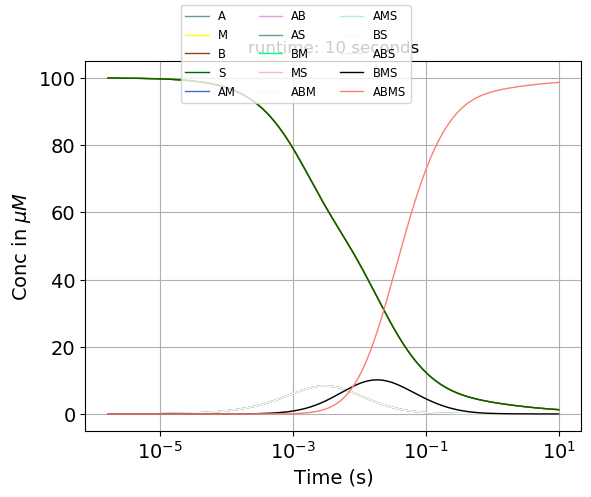

In [9]:
from matplotlib import pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
# nodes_list = ['A','B','M','S','AB','AM','AS','MS','BM','ABM','AMS','ABS','BMS','ABMS']
# nodes_list_repeat = ['A','B','S','AB','AS','AA','BS','ABS','AAB','AAS','AABS']
sim.plot_observable(nodes_list, ax=ax,legend=False,seed=198)
ax.set_title("runtime: " + str(runtime) + " seconds")
handles,labels = ax.get_legend_handles_labels()
ax.set_xscale("log")
fig.legend(handles,nodes_list,loc='upper center',fancybox=True,ncol=3,fontsize='small',markerscale=1.0)
ax.grid(which="major",axis="both")

## Smoothning the data before storing ###

In [10]:
def convert_time_interval(time,conc,time_int=0.1):
    start_time=time[0]
    time_array = []
    conc_array = []
    for i in range(len(time)):
        new_time=time[i]
        ts = new_time/start_time
        if ts>=time_int:
            time_array.append(time[i])
            conc_array.append(conc[i])
            start_time=new_time
    return(time_array,conc_array)
        
    


In [11]:
time_arr = np.array(sim.steps)
complx_conc = np.array(sim.observables[14][1])

sel_time = (time_arr >= 1e-4)
sel_indx = np.argwhere(sel_time)[0][0]

if sel_indx==0:
    sel_indx=1

filter_time,filter_conc = convert_time_interval(time_arr[sel_indx-1:],complx_conc[sel_indx-1:],time_int=1.5)
final_time = np.concatenate((time_arr[:sel_indx],filter_time[:]))
final_conc = np.concatenate((complx_conc[:sel_indx],filter_conc[:]))

### Save yield vs time data to a file ###

The files prefix can be changed (file_pref). This value is also given as the argument for the optimizer. 
Along with yield and time, the runtime, conc_scale are also stored

In [12]:
init_conc = str(vec_rn.initial_copies[0].item())
init_dG = str(vec_rn.rxn_score_vec[0].item())
file_pref = "ConcProfile_Time_RateGrowth_Exp_"
file_name = file_pref + init_conc + "uM"
# file_name = "SampleProfile_vs_dG_" + init_dG + "kT"
with open(file_name,"w") as fl:
    
#     fl.write("#Timestep\tConc\n")
    fl.write("#Rates :\t" )
    for i in range(len(new_kon)):
        fl.write("%4.3f\t"%(new_kon[i]))
    fl.write("\n")
    fl.write("#Conc scale: \t%4.4f \n" %(c_scale))
    fl.write("#Runtime:\t %4.4f\n" %(runtime))
    fl.write("#Timestep\tConc\n")
    for i in range(len(final_time)):
        fl.write("%10.9f\t%10.9f\t%3.2f\t%5.2f" %(final_time[i],final_conc[i],c_scale,runtime))
        for c in range(0,rn.num_monomers):
            fl.write("\t%10.3f" %(vec_rn.initial_copies[c].item()))
            
        fl.write("\n")
        

### Analysis of Mean Square Error

In [13]:
import pandas as pd
from scipy.interpolate import CubicSpline

init_copies = torch.min(vec_rn.initial_copies[0:rn.num_monomers])

# conc_files_pref="rategrowth/ConcProfile_Time_HomoRates_"
conc_files_pref="dG_trap_15/ConcProfile_Time_HomoRates_"
new_file = conc_files_pref+str(init_copies.item())+"uM"
rate_data = pd.read_csv(new_file,delimiter='\t',comment='#',names=['Timestep','Conc','c_scale','runtime','A','B','M','S'])

yield_threshmax=0.89
yield_threshmin=0.01
# time_threshmin=1e-6

time_mask_max = rate_data['Conc']/init_copies>yield_threshmax
time_mask_min = rate_data['Conc']/init_copies>yield_threshmin
time_indx_max = time_mask_max.loc[time_mask_max==True].index[0]
time_indx_min = time_mask_min.loc[time_mask_min==True].index[0]
time_threshmax=rate_data['Timestep'][time_indx_max]
time_threshmin=rate_data['Timestep'][time_indx_min]

print(time_threshmin)

mask1 = (rate_data['Timestep']>=time_threshmin) & (rate_data['Timestep']<time_threshmax)
exp_time = np.array(rate_data['Timestep'][mask1])
exp_conc = np.array(rate_data['Conc'][mask1])

cs_inter = CubicSpline(exp_time,exp_conc)
time_points = np.geomspace(time_threshmin,time_threshmax,num=10)

conc_points = cs_inter(time_points)


time_array = np.array(sim.steps)
conc_array = np.array(sim.observables[14][1])


mse = 0
total_time_diff=0
mse_val=[]
for e_indx in range(len(time_points)):
    curr_time = time_points[e_indx]
    time_diff = (np.abs(time_array-curr_time))
    get_indx = np.argmin(time_diff)
    total_time_diff+=time_diff[get_indx]
#     print(mse)
    curr_mse = torch.abs(((conc_points[e_indx] - conc_array[get_indx])/init_copies))
    mse = mse+ curr_mse
    mse_val.append(curr_mse)

mse_mean=mse/len(time_points)
print(total_time_diff)
print("SSE: ",mse)
print("MEAN SSE: ",mse_mean)
print("Exp Yield: ",conc_points[e_indx]/init_copies,"Sim Yield: ",conc_array[get_indx]/init_copies, "  at time threshold: ",time_threshmax)

FileNotFoundError: [Errno 2] No such file or directory: 'dG_trap_15/ConcProfile_Time_HomoRates_100.0uM'

In [14]:
time_arr = np.array(sim.steps)
complx_conc = np.array(sim.observables[14][1])

sel_time = (time_arr >= 1e-4)
sel_indx = np.argwhere(sel_time)[0][0]

if sel_indx==0:
    sel_indx=1

filter_time,filter_conc = convert_time_interval(time_arr[sel_indx-1:],complx_conc[sel_indx-1:],time_int=1.5)
final_time = np.concatenate((time_arr[:sel_indx],filter_time[:]))
final_conc = np.concatenate((complx_conc[:sel_indx],filter_conc[:]))